In [1]:
import numpy as np
from keras import backend as K
from keras.objectives import mean_squared_error
def log_poisson(y_true, log_y_pred):
    return K.mean(K.exp(log_y_pred) - y_true * log_y_pred, axis=-1)

def poi_gau_mix(y_true, log_y_pred):
    return log_poisson(y_true, log_y_pred) + 0.01*mean_squared_error(y_true, K.exp(log_y_pred))

Using Theano backend.


In [2]:
# from keras.layers import Embedding, Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers import Dense, Dropout, Activation, Embedding, Input
from keras.models import Model
from keras.constraints import MaxNorm
from keras.layers.advanced_activations import ELU

from keras.models import Model, Sequential
from keras.layers import Dense, LSTM

# create the model

input_dim = 3
sequence_len = 50
embed_dim = 8

input_shape = (sequence_len, input_dim)

print('Build model...')
mo = Sequential()
mo.add(LSTM(embed_dim, dropout_W=0.2, dropout_U=0.2, input_shape=input_shape))  # try using a GRU instead, for fun
mo.add(Dense(1))
mo.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
mo.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# print(model.summary())
# # model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=64)

Build model...


In [3]:
filepath = "mo1keras"
# mo.load_weights(filepath)

In [4]:
mo.optimizer.lr.set_value(.01)

In [5]:
from keras.callbacks import LearningRateScheduler
def scheduler(epoch):
    if epoch == 15:
        mo.optimizer.lr.set_value(.01)
    if epoch == 20:
        mo.optimizer.lr.set_value(.005)
    return float(mo.optimizer.lr.get_value())

change_lr = LearningRateScheduler(scheduler)

In [6]:
from scipy.io import loadmat
import six
def mat_to_data(path):
    mat = loadmat(path)
    names = mat['dataStruct'].dtype.names
    ndata = {n: mat['dataStruct'][n][0, 0] for n in names}
    for kk,vv in six.iteritems(ndata):
#         print(vv.shape)
        if vv.shape == (1,1):
            ndata[kk] = vv[0,0]
    return ndata

def get_label(infile):
    return infile.split(".")[-2][-1] == "0"


infile = "./data/1_1_0.mat"
data = mat_to_data(infile)
label = get_label(infile)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def logistic_map(x0, r, N = 100):
    x=x0
    nn = 0
    yield x
    while True:
        nn += 1
        if nn >= N:
            raise StopIteration
        x = r*x*(1-x)
        yield x
        
def F(N):
    a,b = 0, 10
    nn = 0
    yield a, b
    while True:
        nn += 1
        if nn >= N:
            raise StopIteration
        a, b = a - 2*b + 1, a - 2*b - 1
        yield a, b

def delay_embedding(series, shift = 3):
#     print(len(series))
    de = np.vstack([np.roll(series, nn) for nn in range(shift)])[:, shift-1:]
#     print(de.shape)
    return de

def get_embedded_chunks(params,
                    shift = 3,
                    chunk_len = 50,
                    num_chunks = 500,):
    total_len = chunk_len * num_chunks + shift -1

    series = list(logistic_map(*params, N=total_len))
    de = delay_embedding(series, shift = shift)
    return de.reshape(shift, chunk_len ,-1).transpose(2,1,0)

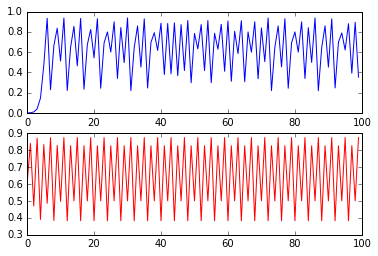

In [37]:
param_chaotic = (7.910e-4, 3.74922)
param_periodic = (0.6, 3.5)

N= 100
series_ch = list(logistic_map(*param_chaotic, N=N))
series_per = list(logistic_map(*param_periodic, N=N))

fig, axs = plt.subplots(2)

axs[0].plot(series_ch)
axs[1].plot(series_per, c='r')

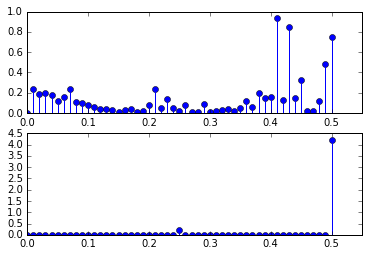

In [32]:
from scipy import signal

fig, axs = plt.subplots(2)
axs[0].stem(*signal.periodogram(series_ch))
axs[1].stem(*signal.periodogram(series_per), c="r")
for ax in axs:
    ax.set_xlim([0,0.55])

In [8]:
num_chunks = 500

xx_ch = get_embedded_chunks(param_chaotic,
                    shift = 3,
                    chunk_len = 50,
                    num_chunks = num_chunks,)
yy_ch = np.zeros(num_chunks, dtype=bool)

xx_per = get_embedded_chunks(param_periodic,
                    shift = 3,
                    chunk_len = 50,
                    num_chunks = num_chunks,)
yy_per = np.ones(num_chunks, dtype=bool)

tt = np.random.permutation(num_chunks*2)
xx = np.vstack([xx_ch, xx_per])[tt]
yy = np.hstack([yy_ch, yy_per])[tt]
print(xx.shape)

(1000, 50, 3)


imdb example:

    X (25000 , 80)
      (num_samples, seq_len)
     
eeg:

    X (num_samples, seq_len, embedding_dim)

In [10]:
from itertools import cycle
datadir = "data/"
BATCH_SIZE = 250

mo.fit(xx, yy,
             nb_epoch=100,
             callbacks=[change_lr])

# mo.fit_generator(gen, nb_worker=1,
#                  nb_epoch=300, samples_per_epoch = BATCH_SIZE,
#                  callbacks=[change_lr])

Epoch 1/100
1000/1000 [==============================] - 0s - loss: 0.6805 - acc: 0.5410     
Epoch 2/100
1000/1000 [==============================] - 0s - loss: 0.5806 - acc: 0.7430     
Epoch 3/100
1000/1000 [==============================] - 0s - loss: 0.5166 - acc: 0.7650     
Epoch 4/100
1000/1000 [==============================] - 0s - loss: 0.5236 - acc: 0.7660     
Epoch 5/100
1000/1000 [==============================] - 0s - loss: 0.5076 - acc: 0.7620     
Epoch 6/100
1000/1000 [==============================] - 0s - loss: 0.4434 - acc: 0.8000     
Epoch 7/100
1000/1000 [==============================] - 0s - loss: 0.4813 - acc: 0.7630     
Epoch 8/100
1000/1000 [==============================] - 0s - loss: 0.3790 - acc: 0.8310     
Epoch 9/100
1000/1000 [==============================] - 0s - loss: 0.4547 - acc: 0.7720     
Epoch 10/100
1000/1000 [==============================] - 0s - loss: 0.4212 - acc: 0.7770     
Epoch 11/100
1000/1000 [==============================] - 0